In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel(r"/kaggle/input/acr-data/ACR unnormalised.xlsx")
def normalised(database):
    mean = np.mean(database, axis=0)
    std = np.std(database, axis=0)
    return((database-mean)/std)

In [3]:
Train, Test = train_test_split(df, train_size=0.8, random_state=42)
Train_in = Train[['I1','I2','I3','I4','I5','I6','I7']]
Test_in = Test[['I1','I2','I3','I4','I5','I6','I7']]
Train_out = Train['OUT1']
Test_out = Test['OUT1']

#Train_in[['I3','I4','I5']] = normalised(Train_in[['I3','I4','I5']])
#Test_in[['I3','I4','I5']] = normalised(Test_in[['I3','I4','I5']])

Train_out = pd.DataFrame((Train_out*100)-97)
Test_out = pd.DataFrame((Test_out*100)-97)

In [4]:
'''converting into torch tensors'''

xtr = torch.tensor(Train_in.values, dtype=torch.float32)
xte = torch.tensor(Test_in.values, dtype=torch.float32)
ytr = torch.tensor(Train_out.values, dtype=torch.float32)
yte = torch.tensor(Test_out.values, dtype=torch.float32)

In [5]:
class regmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(7,5)
        self.layer2 = nn.Linear(5,3)
        self.layer3 = nn.Linear(3,1)
        
    def forward(self, x):
        y = self.layer1(x)
        y = torch.tanh(y)
        y = self.layer2(y)
        y =  torch.tanh(y)
        y = self.layer3(y)
        y = torch.tanh(y)
        
        return y 

In [9]:
torch.manual_seed(123)
model1 = regmodel()
lrate = 0.005 
n_iters = 1000
optimizer = torch.optim.Adam(model1.parameters(), lr = lrate)
loss = nn.MSELoss()

for i in range(n_iters):
    optimizer.zero_grad()
    y_pred = model1(xtr)
    l = loss(y_pred,ytr)
    l.backward()
    optimizer.step()
    
    training_rmse = torch.sqrt(l)/100
    
    if i%100 == 0:
        print(f"Epoch : {i} | MSE loss : {l}")
        
with torch.no_grad():
    model1.eval()
    y_pred1 = model1(xte)
    l = loss(y_pred1,yte)
    rmse = torch.sqrt(l)
    test_rmse = rmse/100
print(f"MSE : {l} | RMSE : {rmse}")

Epoch : 0 | MSE loss : 0.11146683990955353
Epoch : 100 | MSE loss : 0.07459040731191635
Epoch : 200 | MSE loss : 0.049713265150785446
Epoch : 300 | MSE loss : 0.045992981642484665
Epoch : 400 | MSE loss : 0.04787186533212662
Epoch : 500 | MSE loss : 0.042211487889289856
Epoch : 600 | MSE loss : 0.038432568311691284
Epoch : 700 | MSE loss : 0.03486572578549385
Epoch : 800 | MSE loss : 0.035486169159412384
Epoch : 900 | MSE loss : 0.033113058656454086
MSE : 0.036339953541755676 | RMSE : 0.19063040614128113


(178, 1)
(710, 1)


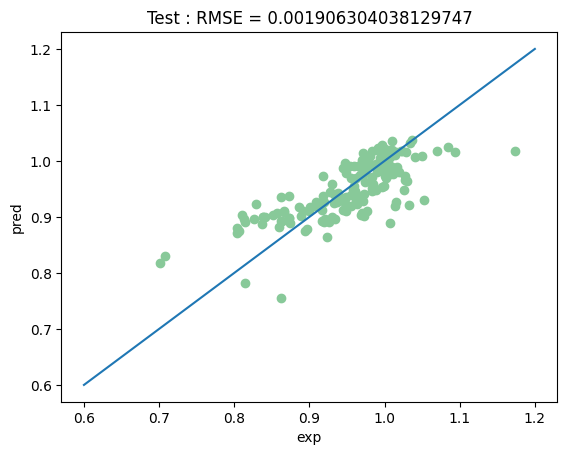

In [10]:
x = np.linspace(0.6,1.2,100)
y =x 
plt.plot(y,x)
Train_plot = Train[['ACR']]
Test_plot = Test[['ACR']]

y_pred1 = (y_pred1+97)/100
y_pred1 = (10**(y_pred1+0.0204))-8.9324
Y = y_pred1.detach().numpy()
print(Y.shape)
print(Train_plot.shape)
plt.scatter(Test_plot,Y,color = '#88c999')
plt.xlabel("exp")
plt.ylabel('pred')
plt.title(f'Test : RMSE = {test_rmse}')
plt.show()

(710, 1)
(710, 1)


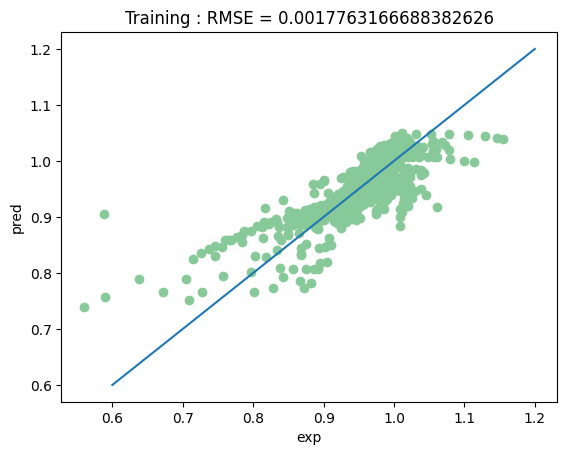

In [11]:
x = np.linspace(0.6,1.2,100)
y =x 
plt.plot(y,x)

y_pred = (y_pred+97)/100
y_pred = (10**(y_pred+0.0204))-8.9324
Y = y_pred.detach().numpy()
print(Y.shape)
print(Train_plot.shape)
plt.scatter(Train_plot,Y,color = '#88c999')
plt.xlabel("exp")
plt.ylabel('pred')
plt.title(f'Training : RMSE = {training_rmse}')
plt.show()

In [15]:
class hmodel(nn.Module):
    def __init__(self, hiddendim):
        super().__init__()
        self.inlayer = nn.Linear(7,hiddendim)
        self.outlayer = nn.Linear(hiddendim,1)
        
    def forward(self,x):
        y = self.inlayer(x)
        y = torch.tanh(y)
        y = self.outlayer(y)
        y = torch.tanh(y)
        
        return y

In [17]:
modela = hmodel(5)
modelb = hmodel(7)
modelc = hmodel(10)

lrate = 0.005 
n_iters = 1000
o1 = torch.optim.Adam(modela.parameters(), lr = lrate)
o2 = torch.optim.Adam(modelb.parameters(), lr = lrate)
o3 = torch.optim.Adam(modelc.parameters(), lr = lrate)

for i in range(n_iters):
    o1.zero_grad()
    o2.zero_grad()
    o3.zero_grad()
    
    y_preda = modela(xtr)
    y_predb = modelb(xtr)
    y_predc = modelc(xtr)
    
    la = loss(y_preda,ytr)
    lb = loss(y_predb,ytr)
    lc = loss(y_predc,ytr)
    
    la.backward()
    lb.backward()
    lc.backward()
    
    o1.step()
    o2.step()
    o3.step()
    
    
    
    if i%100 == 0:
        print(f"Epoch : {i} | MSE loss -> Model A: {la} / Model B: {lb} / Model C: {lc}")

training_rmsea = torch.sqrt(la)/100 
training_rmseb = torch.sqrt(lb)/100 
training_rmsec = torch.sqrt(lc)/100 

print(f'Training RMSE -> Model A: {training_rmsea:.5f} / Model B: {training_rmseb:.5f} / Model C: {training_rmsec:.5f}')

with torch.no_grad():
    modela.eval()
    modelb.eval()
    modelc.eval()
    
    y_preda = modela(xte)
    y_predb = modelb(xte)
    y_predc = modelc(xte)
    
    la = loss(y_preda,yte)
    lb = loss(y_predb,yte)
    lc = loss(y_predc,yte)
    
    rmsea = torch.sqrt(la)/100
    rmseb = torch.sqrt(lb)/100
    rmsec = torch.sqrt(lc)/100
    
print(f"Testing RMSE -> Model A: {rmsea:.5f} / Model B: {rmseb:.5f} / Model C: {rmsec:.5f}")

Epoch : 0 | MSE loss -> Model A: 0.11450066417455673 / Model B: 1.6258020401000977 / Model C: 0.4450649321079254
Epoch : 100 | MSE loss -> Model A: 0.08675185590982437 / Model B: 0.07110598683357239 / Model C: 0.07935234159231186
Epoch : 200 | MSE loss -> Model A: 0.08671045303344727 / Model B: 0.062051497399806976 / Model C: 0.06375609338283539
Epoch : 300 | MSE loss -> Model A: 0.08669354766607285 / Model B: 0.05865732580423355 / Model C: 0.058901235461235046
Epoch : 400 | MSE loss -> Model A: 0.08668580651283264 / Model B: 0.05700264498591423 / Model C: 0.05731545016169548
Epoch : 500 | MSE loss -> Model A: 0.08668240904808044 / Model B: 0.05650860071182251 / Model C: 0.056387145072221756
Epoch : 600 | MSE loss -> Model A: 0.08668096363544464 / Model B: 0.05543677508831024 / Model C: 0.05572059378027916
Epoch : 700 | MSE loss -> Model A: 0.08667367696762085 / Model B: 0.0548488013446331 / Model C: 0.05532544478774071
Epoch : 800 | MSE loss -> Model A: 0.08666321635246277 / Model B: 

In [20]:
#pip install torchviz

#from torchviz import make_dot


#make_dot(y_pred.mean(), params=dict(model1.named_parameters()))